In [1]:
import torch
from matplotlib import pyplot as plot
from torch.nn import functional as F

In [2]:
with open("names.txt", "r") as f:
    names = [_.strip() for _ in f.readlines()]

names[0:5], len(names)

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], 32033)

In [3]:
chars = list(set("".join(names)))
chars.insert(0, ".")
chars

['.',
 'v',
 'f',
 'b',
 'x',
 'i',
 'g',
 'r',
 't',
 'y',
 'z',
 'q',
 'a',
 'p',
 'c',
 'm',
 's',
 'e',
 'n',
 'j',
 'w',
 'l',
 'u',
 'h',
 'o',
 'k',
 'd']

In [4]:
ctoi = { c:i for i, c in enumerate(chars)}
itoc = { i:c for i, c in enumerate(chars)}

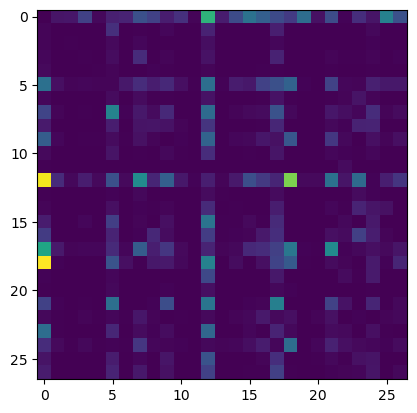

In [5]:
N = torch.zeros((27, 27), dtype=torch.int) # N is count vector

for x in names:
    x = "." + x + "."
    for c1, c2 in zip(x, x[1:]):
        c1i = ctoi[c1]
        c2i = ctoi[c2]
        N[c1i, c2i] += 1
        
plot.imshow(N)

In [6]:
P = N / N.sum(dim=1, keepdims=True)
P[5,:].sum()

tensor(1.)

In [7]:
bigrams = []
for x in names:
    x = "." + x + "."
    for c1, c2 in zip(x, x[1:]):
        bigrams.append((c1, c2))

In [8]:
logp = 0;
for c1, c2 in bigrams:
    c1 = ctoi[c1]
    c2 = ctoi[c2]
    logp += P[c1, c2].log().item()

nll = -logp / len(bigrams)
nll

2.454014497322693

In [9]:
gen = torch.Generator()
gen.manual_seed(2147483647)

for _ in range(10):
    sample = "."
    while(True):
        c1 = sample[-1]
        i1 = ctoi[c1]
        i2 = torch.multinomial(P[i1], 1, generator=gen).item()
        sample += itoc[i2]

        if i2 == 0:
            break
    
    print(sample)

.bioda.
.amrarlionardonnth.
.a.
.dynzach.
.ckarrll.
.qur.
.r.
.ja.
.deslishatelyawey.
.y.


## Bigram Neural Net

In [10]:
def create_bigram_ds(names): 
    x = []
    y = []
    for s in names:
        s = "." + s + "."
        for c1, c2 in zip(s, s[1:]):
            x.append(ctoi[c1])
            y.append(ctoi[c2])
    
    x = F.one_hot(torch.tensor(x), num_classes=27).float()
    y = torch.tensor(y)
    
    return x, y
    
x, y = create_bigram_ds(names)
x.shape

torch.Size([228146, 27])

In [11]:
train, dev, test = torch.utils.data.random_split(names, [0.8, 0.1, 0.1])
len(train), len(dev), len(test)

(25627, 3203, 3203)

In [12]:
train_ds = create_bigram_ds(train)
dev_ds = create_bigram_ds(dev)
test_ds = create_bigram_ds(test)

In [13]:
def cal_loss(W, dataset, decay=0):
    with torch.no_grad():
        X, ys = dataset
        logits = X @ W
        loss = F.cross_entropy(logits, ys)
    
    return loss

In [14]:
def fits(W, train_ds, dev_ds, epoch, decay=0, verbose=True):
    X, ys = train_ds
    n = X.shape[0]
    print_ev = epoch / 10
    
    for i in range(epoch):
        W.grad = None
        logits = X @ W
        
        # counts = logits.exp()
        # probs = counts / counts.sum(1, keepdims=True)
        # loss = -probs[torch.arange(n), ys].log().mean() + decay*(W**2).mean()
        
        loss = F.cross_entropy(logits, ys) + decay*(W**2).mean()
        loss.backward()

        if i % print_ev == 0 and verbose:
            dev_loss = cal_loss(W, dev_ds)
            print(f"train: {loss.item():.4f}  dev: {dev_loss:.4f}")

        W.data -= 10 * W.grad

In [15]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(27, 27, requires_grad=True, generator=g)
fits(W, train_ds, dev_ds, 100)
print("----")
print(f"test: {cal_loss(W, test_ds)}")

train: 3.7315  dev: 3.7342
train: 3.1569  dev: 3.1622
train: 2.9238  dev: 2.9295
train: 2.8028  dev: 2.8084
train: 2.7294  dev: 2.7350
train: 2.6802  dev: 2.6859
train: 2.6449  dev: 2.6507
train: 2.6184  dev: 2.6244
train: 2.5978  dev: 2.6040
train: 2.5815  dev: 2.5879
----
test: 2.568952798843384


In [16]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(27, 27, requires_grad=True, generator=g)
fits(W, train_ds, dev_ds, 100, 0.05)
print("----")
print(f"test: {cal_loss(W, test_ds)}")

train: 3.7798  dev: 3.7342
train: 3.1930  dev: 3.1573
train: 2.9581  dev: 2.9247
train: 2.8376  dev: 2.8044
train: 2.7654  dev: 2.7318
train: 2.7177  dev: 2.6836
train: 2.6839  dev: 2.6493
train: 2.6590  dev: 2.6238
train: 2.6400  dev: 2.6042
train: 2.6252  dev: 2.5888
----
test: 2.5708320140838623


In [17]:
g = torch.Generator().manual_seed(2147483647)

def sample_bi(W):
    res = "."
    with torch.no_grad():
        while(True):
            c = res[-1]
            x = torch.tensor(ctoi[c])
            x = F.one_hot(x, num_classes=27).reshape(1, 27).float()

            logits = x @ W
            counts = logits.exp()
            probs = counts / counts.sum(dim=1, keepdims=True)
            ix = torch.multinomial(probs, 1, generator=g).item()
            c2 = itoc[ix]

            res += c2
            if c2 == ".":
                break;

        return res

for _ in range(10):
    print(sample_bi(W))

.bioda.
.amrarliqusedqwoth.
.a.
.dynzach.
.cnarrlqdqqull.
.ja.
.deslishatelyawmo.
.y.
.dyne.
.rol.


# Trigram Neural Net

In [18]:
def create_tri_ds(names): 
    x1 = []
    x2 = []
    y = []
    for s in names:
        s = ".." + s + ".."
        for c1, c2, c3 in zip(s, s[1:], s[2:]):
            x1.append(ctoi[c1])
            x2.append(ctoi[c2])             
            y.append(ctoi[c3])            
                                          
    x1 = F.one_hot(torch.tensor(x1), num_classes=27).float()
    x2 = F.one_hot(torch.tensor(x2), num_classes=27).float()
    x = torch.cat([x1, x2], dim=1) # (num_data, 2 * char_num)
    y = torch.tensor(y)
    return x, y
    
x, y = create_tri_ds(train)
x.shape

torch.Size([208195, 54])

In [19]:
train_tds = create_tri_ds(train)
dev_tds = create_tri_ds(dev)
test_tds = create_tri_ds(test)

In [20]:
g = torch.Generator().manual_seed(2147483647)
print("decay: 0")
print("----")
W = torch.randn(2 * 27, 27, requires_grad=True, generator=g)
fits(W, train_tds, dev_tds, 100)
print("----")
print(f"test: {cal_loss(W, test_tds)}")

decay: 0
----
train: 4.1078  dev: 4.1029
train: 2.8315  dev: 2.8253
train: 2.5597  dev: 2.5544
train: 2.4277  dev: 2.4244
train: 2.3492  dev: 2.3479
train: 2.2982  dev: 2.2982
train: 2.2623  dev: 2.2633
train: 2.2356  dev: 2.2372
train: 2.2147  dev: 2.2169
train: 2.1980  dev: 2.2005
----
test: 2.187288284301758


In [21]:
g = torch.Generator().manual_seed(2147483647)
print("decay: 0.01")
print("----")
W = torch.randn(2 * 27, 27, requires_grad=True, generator=g)
fits(W, train_tds, dev_tds, 100, 0.1)
print("----")
print(f"test: {cal_loss(W, test_tds)}")

decay: 0.01
----
train: 4.2048  dev: 4.1029
train: 2.9078  dev: 2.8171
train: 2.6292  dev: 2.5449
train: 2.4938  dev: 2.4150
train: 2.4135  dev: 2.3390
train: 2.3613  dev: 2.2899
train: 2.3246  dev: 2.2556
train: 2.2972  dev: 2.2301
train: 2.2759  dev: 2.2103
train: 2.2589  dev: 2.1946
----
test: 2.1817398071289062


In [22]:
def param_expr(decay, epoch):
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn(2 * 27, 27, requires_grad=True, generator=g)
    fits(W, train_tds, dev_tds, epoch, decay, verbose=False)
    loss = cal_loss(W, test_tds)
    print(f"decay: {decay:.4f}  test: {loss:.4f}")

In [23]:
epoch = 200
param_expr(0, epoch)
param_expr(0.01, epoch)
param_expr(0.05, epoch)
param_expr(0.1, epoch)

decay: 0.0000  test: 2.1224
decay: 0.0100  test: 2.1221
decay: 0.0500  test: 2.1215
decay: 0.1000  test: 2.1224


In [24]:
epoch = 800
param_expr(0, epoch)
param_expr(0.01, epoch)
param_expr(0.05, epoch)
param_expr(0.1, epoch)

decay: 0.0000  test: 2.0721
decay: 0.0100  test: 2.0725
decay: 0.0500  test: 2.0773
decay: 0.1000  test: 2.0861


In [25]:
def sample_tri(W):
    # rdn_ix = torch.randint(1, 26, (1, )).item()
    sample = ".."
    while(True):
        c1 = sample[-2]
        c2 = sample[-1]
        x1 = F.one_hot(torch.tensor([ctoi[c1]]), num_classes=27).float()
        x2 = F.one_hot(torch.tensor([ctoi[c2]]), num_classes=27).float()
        x = torch.cat([x1, x2], dim=1)

        logits = x @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdims=True)
        ix = torch.multinomial(probs, 1, generator=gen).item()
        c3 = itoc[ix]

        sample += c3
        if c3 == ".":
            break;
            
    return sample

for _ in range(10):
    print(sample_tri(W))

..dyne.
..rol.
..diseix.
..riqatsep.
..jaxdlicqfuronn.
..eefjshtrayuahuwvtalil.
..kjxol.
..ariya.
..seyh.
..yah.


# Exercise 5: Why use `F.cross_entropy`

In [76]:
g = torch.Generator().manual_seed(2147483647)
n = 100
feature_size = 1000

W = torch.randn(feature_size, feature_size, requires_grad=False, generator=g)
X = torch.randn(n, feature_size, requires_grad=True, generator=g)
y = torch.randint(0, feature_size-1, (n,), generator=g)    

Manual calculation

We can see that when logits is large (i.e. 100), we can easily each max value range when taking the exponent (`e^100`). Also observe that larger feature size would result in have larger logits value.

In [74]:
logits = X@W
print(f"logits max: {logits.max().item()}", )

counts = logits.exp()
print(f"counts max: {counts.max().item()}", )

probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(y.shape[0]), y].log().mean()
loss

logits max: 137.92921447753906
counts max: inf


tensor(nan, grad_fn=<NegBackward0>)

Using `F.cross_entropy`

In [75]:
X, W, y = init_data()

logits = X@W
loss = F.cross_entropy(logits, y)
loss

tensor(23.7999, grad_fn=<NllLossBackward0>)

# Exercise Answer

1. Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

    > Trigram model seem to yield better loss

2. Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
    
    
3. use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?
    
    
    > When training with 800 epoch, I yield an unexpected test loss pattern. 
    > ```
        decay: 0.0000  test: 2.0665
        decay: 0.0100  test: 2.0674
        decay: 0.0500  test: 2.0733
        decay: 0.1000  test: 2.0831
    > ```  
    > I expected regularization should help improve test loss, but from the experiments, no regularization seems to yield best test loss


    
    
4. We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

1. Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?